## Trabajo final de Text Mining
### Notebook de prueba de Convolutional Neural Networks

### Cargo las librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs, nltk

sns.set_style("whitegrid")
np.random.seed(0)

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')

stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

### Cargo los word embeddings (1 millón de vectores)

In [3]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('../Maestría en Data Mining/wiki-news-300d-1M-subword.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


999995it [02:20, 7101.54it/s]


found 999995 word vectors


### Construyo el F-Score

In [4]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Cargo el dataset y grafico la distribución (según largo de la afirmación)

In [5]:
df = pd.read_csv("7Truth7LiesDataset.csv",sep = ',', quotechar="'",escapechar="\\")
df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
df = df.rename(columns={"class":"clase"}) # class es palabra reservada
df['clase'] = np.where(df['clase'] == 'truth', 1, 0)

num train:  5017
num test:  2151


c:\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


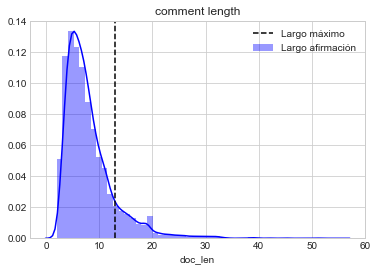

In [6]:
#load data
train_df, test_df =  train_test_split(df, stratify=df.clase, test_size=0.3, random_state = 123)

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

y_train = train_df['clase']

#visualize word distribution
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='Largo afirmación')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='Largo máximo')
plt.title('comment length'); plt.legend()
plt.show()

### Preproceso el texto

#### Armo un PoS Tagging a ver qué da

In [7]:
def clean_text(text):
    text = re.sub('(\[")|("\])'," ",text)
    return text.lower().strip()

pru= train_df.text
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

trainset_texto_pos = columna


pru= test_df.text
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    
testset_texto_pos = columna
    
trainset_texto_pos[:10]

['i_N will_M stay_V up_R till_R 12_C am_V tomorrow_N ._.',
 'we_P sleep_V in_I night_N',
 'i_N was_V in_I hurry_N yesterday_N and_C instead_R of_I taking_V the_D elevator_N from_I second_J floor_N i_N jumped_V down_R to_T earth_N ._.',
 'i_N am_V in_I my_P forties_N ._.',
 'there_E is_V no_D evidence_N that_I america_N is_V an_D oligarchy_N ._.',
 'a_D blue_J whale_N only_R eats_V squid_N ._.',
 'kodak_N has_V gone_V bankrupt_J',
 'i_N was_V lying_V when_W i_N said_V i_J love_V you_P ._.',
 'my_P friend_N can_M smell_V with_I the_D help_N of_I his_P fingers_N ._.',
 'orange_N is_V blue_J ._.']

In [8]:
raw_docs_train = trainset_texto_pos #train_df['text'].tolist() 
raw_docs_test = testset_texto_pos #test_df['text'].tolist() 
num_classes = 2

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    processed_docs_train.append(" ".join(tokens))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for


print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████████████████████████████████████████████████████████████████████| 2151/2151 [00:00<00:00, 166450.46it/s]


tokenizing input data...
dictionary size:  7703


### Defino los parámetros y la matriz para el embedding

In [9]:
#training params
batch_size = 256
num_epochs = 10

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [10]:
#embedding matrix
print('Preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('Number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix...
Number of null word embeddings: 235


#### Ejemplos de palabras no encontradas

In [11]:
print("Muestra de palabras no encontradas: ", np.random.choice(words_not_found, 10))

Muestra de palabras no encontradas:  ['galchen' 'tragetic' 'jayanthi' 'directtv' 's80' 'seaso' 'jamestown'
 'thayumanavaswamy' 'bernake' 'sampras']


### Construyo la CNN Unidimensional

In [12]:
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  #Es 1 porque es una clase binaria

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[f1])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 300)           2310900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 64)            134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 64)             28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

### Ajusto la Neural Network y la evalúo en validación

In [14]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.2, shuffle=True, verbose=2)

Train on 4013 samples, validate on 1004 samples
Epoch 1/10
 - 2s - loss: 0.6999 - f1: 0.4584 - val_loss: 0.6947 - val_f1: 0.6701
Epoch 2/10
 - 1s - loss: 0.6932 - f1: 0.5211 - val_loss: 0.7074 - val_f1: 0.0941
Epoch 3/10
 - 1s - loss: 0.6846 - f1: 0.4798 - val_loss: 0.6882 - val_f1: 0.5151
Epoch 4/10
 - 1s - loss: 0.6704 - f1: 0.5549 - val_loss: 0.6842 - val_f1: 0.5084
Epoch 5/10
 - 2s - loss: 0.6341 - f1: 0.6142 - val_loss: 0.7310 - val_f1: 0.6692
Epoch 6/10
 - 3s - loss: 0.5605 - f1: 0.7159 - val_loss: 0.7436 - val_f1: 0.4450
Epoch 7/10
 - 2s - loss: 0.4803 - f1: 0.7747 - val_loss: 0.8624 - val_f1: 0.3289
Epoch 8/10
 - 1s - loss: 0.4011 - f1: 0.8253 - val_loss: 0.8821 - val_f1: 0.6289
Epoch 00008: early stopping


#### Grafico el desempeño

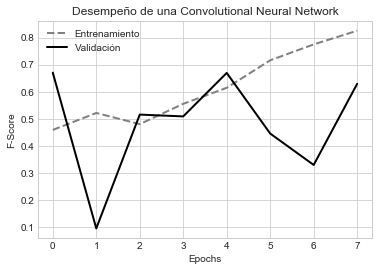

In [15]:
plt.figure()
plt.plot(hist.history['f1'], lw=2.0, color='grey',linestyle = '--', label='Entrenamiento')
plt.plot(hist.history['val_f1'], lw=2.0, color='black', label='Validación')
plt.title('Desempeño de una Convolutional Neural Network')
plt.xlabel('Epochs')
plt.ylabel('F-Score')
plt.legend(loc='upper left')
plt.show()

### Predigo los valores de test

In [16]:
y_test = model.predict(word_seq_test)

In [20]:
y_test = np.where(y_test > 0.5, 1, 0)

In [21]:
submission_df = test_df
submission_df['prediccion'] = y_test 
submission_df.to_csv("./cnn_fasttext_submission.csv", index=False)

c:\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
